# Fraud detection with machine learning **method**

### FI505E - Coding and Data Science for Accounting and Finance

Fraud is a crime that can be difficult to detect, and most importantly, fraud needs to be detected prior to the transaction because if it is detected too late, then the fraud has already occurred, and the company will lose the money.  Machine learning is now a great tool used to determine which transactions are fraud. By using a big dataset, machine learning can assess, to some extent, if a transaction is fraudulent or not. 

In our project you should use different models on a sample of 10 000 transactions to detect which transactions are fraud or not.
 Three different classifiers: logistics regression, support vector machine, and tree decision.

The database you are dealing is composed of 10,000 entry, in this case transactions. Each transaction has been detailed thanks to some characteristics. 
Here is a list of them:
-	Total spent in the last 24 hours
-	Merchant's track record of fraudulent transactions which determines the merchant fraud risk
-	Time since the last purchase
-	Average transaction size
-	Time until the card expires 
-	Average number of transactions per day
-	Change over the previous day in merchant sales 
-	Amount spent in the transaction. 
-	Class: to state if the transaction is a fraud or not


In [151]:
# import packages
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
#Logistic Regression
from sklearn.linear_model import LogisticRegression

# import package to split data set
from sklearn.model_selection import train_test_split
# import confusion_matrix
from sklearn.metrics import confusion_matrix
import pandas as pd

In [152]:
# Import Data  from CSV file
fraud = pd.read_csv("fraud.csv")
fraud.head(5)
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      10000 non-null  int64  
 1   normalized_total_spent_last_24_hours    10000 non-null  float64
 2   normalized_merchant_fraud_risk          10000 non-null  float64
 3   normalized_time_since_last_transaction  10000 non-null  float64
 4   normalized_average_transaction          10000 non-null  float64
 5   normalized_days_till_expiration         10000 non-null  float64
 6   normalized_transaction_time             10000 non-null  float64
 7   normalized_change_in_merchant_sales     10000 non-null  float64
 8   Amount                                  10000 non-null  float64
 9   Class                                   10000 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 781.4 KB


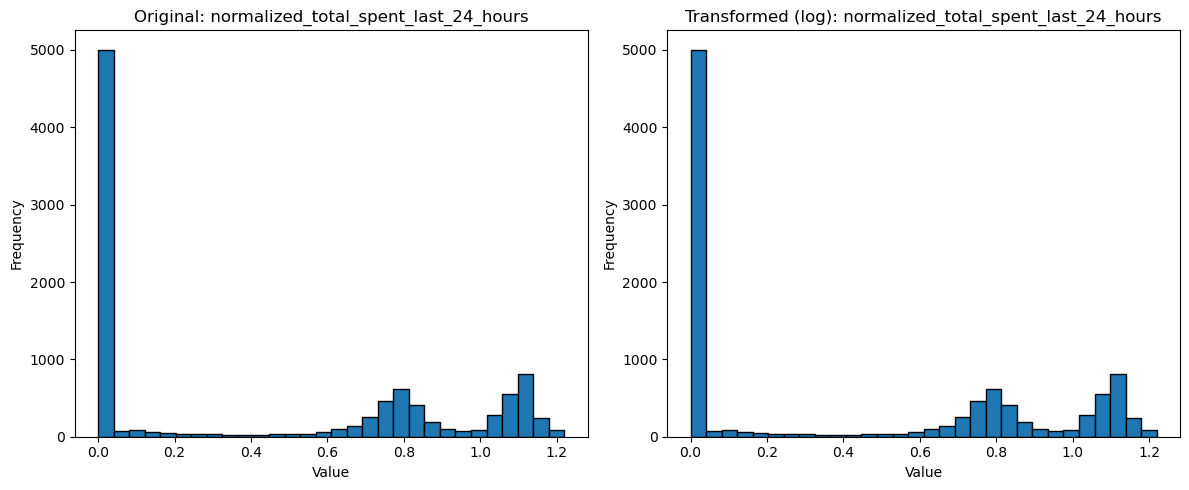

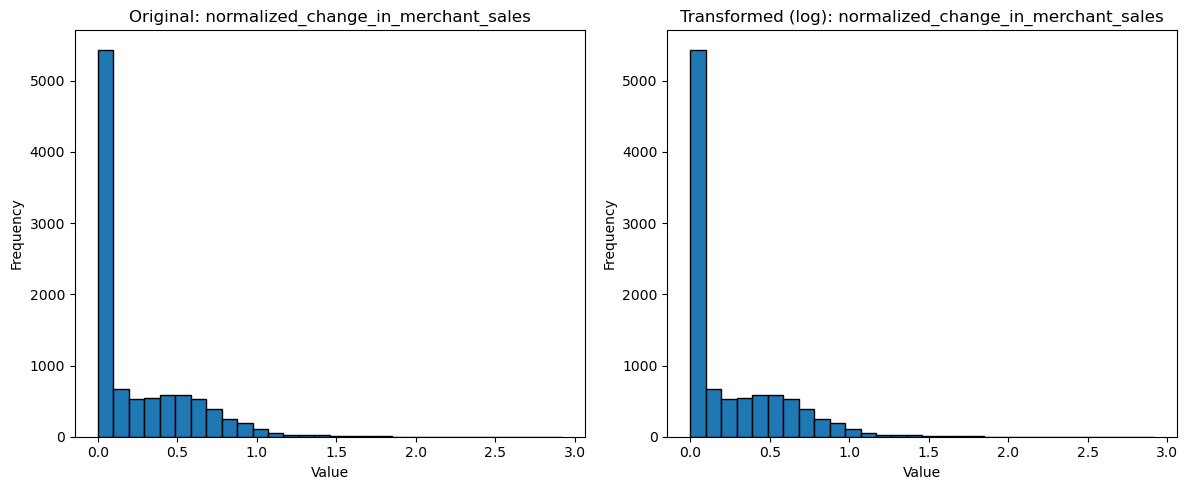

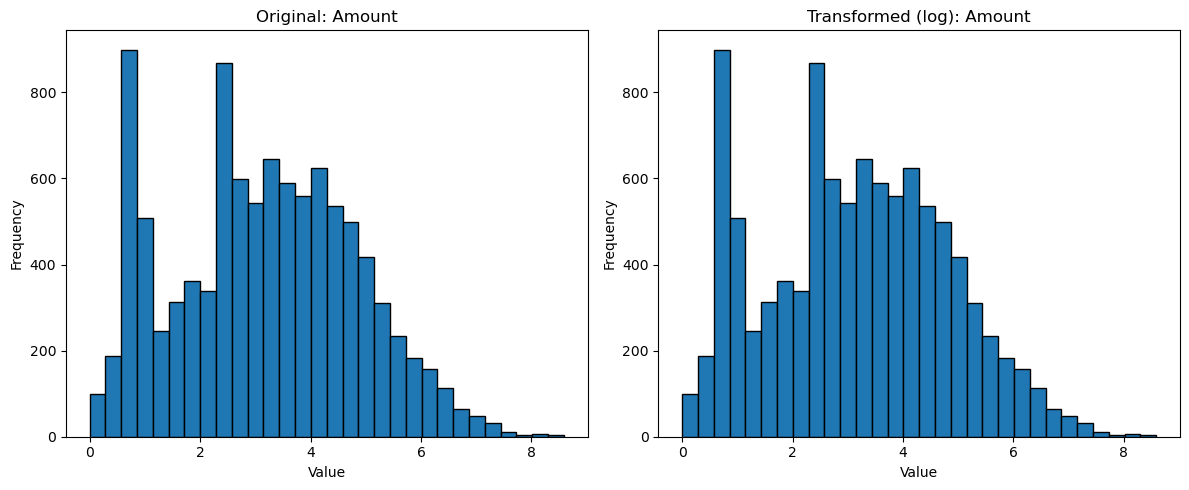

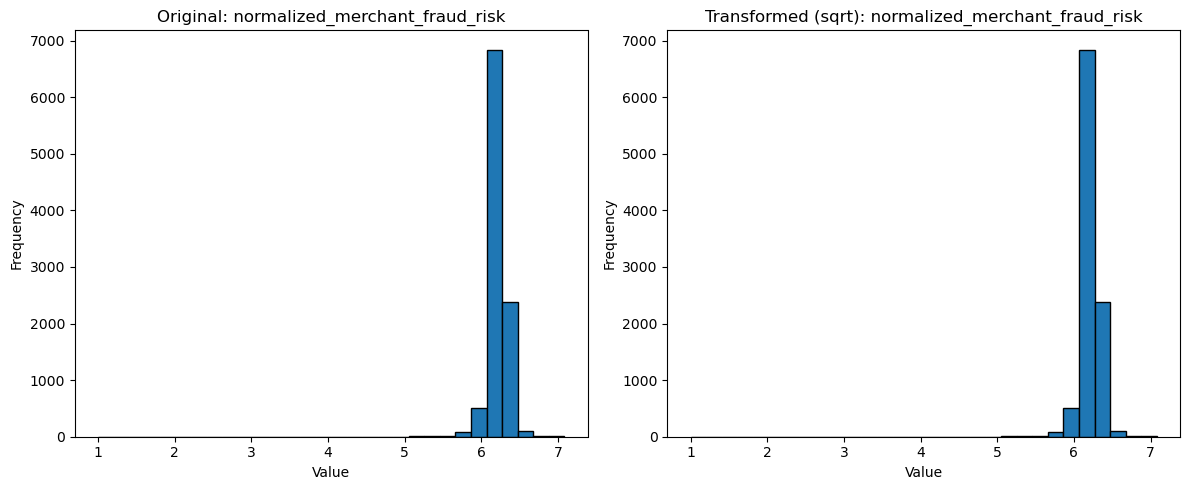

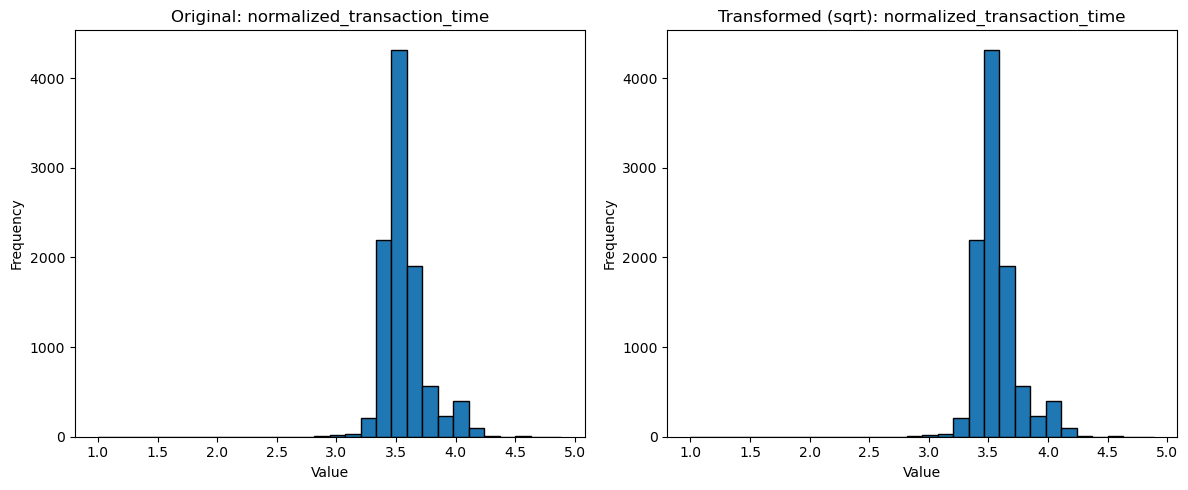

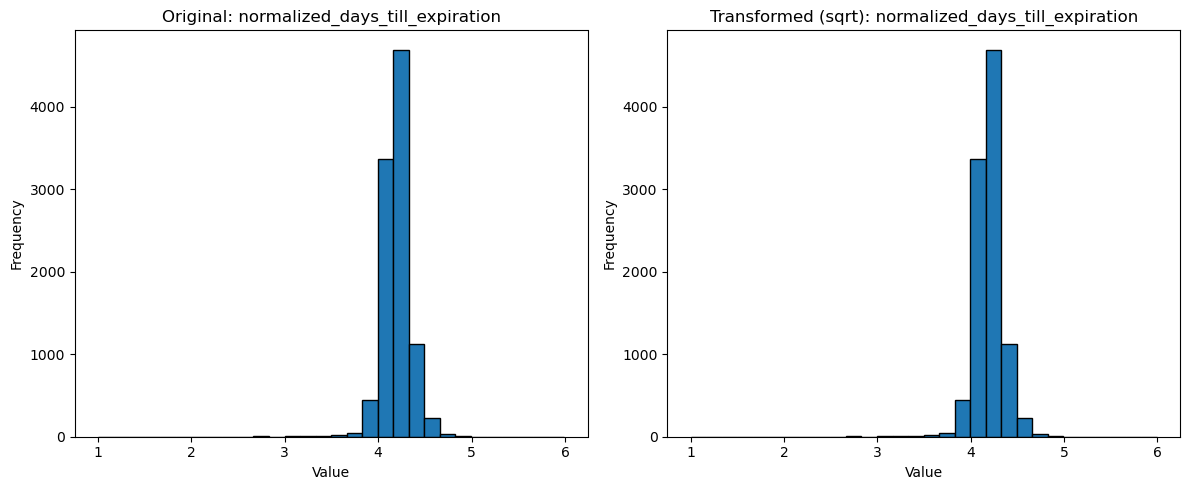

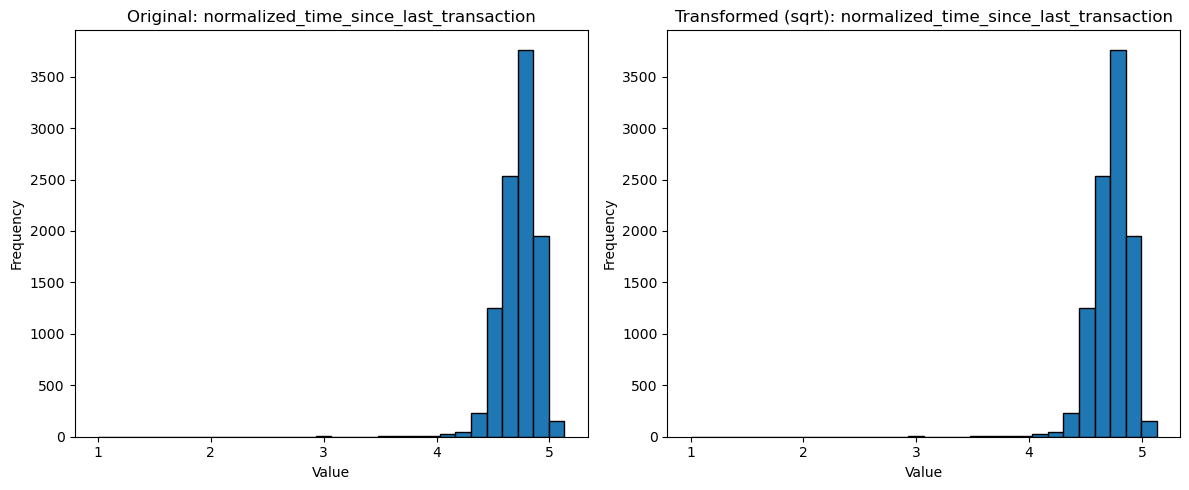

In [132]:

variables_to_transform = {
    "normalized_total_spent_last_24_hours": "log",
    "normalized_change_in_merchant_sales": "log",
    "Amount": "log",
    "normalized_merchant_fraud_risk": "sqrt",
    "normalized_transaction_time": "sqrt",
    "normalized_days_till_expiration": "sqrt",
    "normalized_time_since_last_transaction": "sqrt",
}

# Function to plot original and transformed histograms
def plot_histograms(original, transformed, column, method):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(original, bins=30, edgecolor='black')
    plt.title(f'Original: {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    plt.hist(transformed, bins=30, edgecolor='black')
    plt.title(f'Transformed ({method}): {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Transform variables and update the original dataframe
for column, method in variables_to_transform.items():
    if column in fraud.columns:
        if method == "log":
            # Apply log transformation and handle invalid values
            fraud[column] = np.log1p(fraud[column].clip(lower=0))  # Ensures no negative values for log
        elif method == "sqrt":
            # Apply square root transformation and handle invalid values
            fraud[column] = np.sqrt(fraud[column] - fraud[column].min() + 1)
        
        # Plot histograms for the transformed data
        plot_histograms(fraud[column], fraud[column], column, method)
    else:
        print(f"Column '{column}' not found in the dataset. Skipping.")




Correlation Matrix:
                                              id  \
id                                      1.000000   
normalized_total_spent_last_24_hours   -0.010272   
normalized_merchant_fraud_risk          0.003784   
normalized_time_since_last_transaction -0.008511   
normalized_average_transaction         -0.019414   
normalized_days_till_expiration         0.004856   
normalized_transaction_time             0.006913   
normalized_change_in_merchant_sales     0.002935   
Amount                                 -0.010266   
Class                                   0.002688   

                                        normalized_total_spent_last_24_hours  \
id                                                                 -0.010272   
normalized_total_spent_last_24_hours                                1.000000   
normalized_merchant_fraud_risk                                     -0.014983   
normalized_time_since_last_transaction                              0.019218   
normali

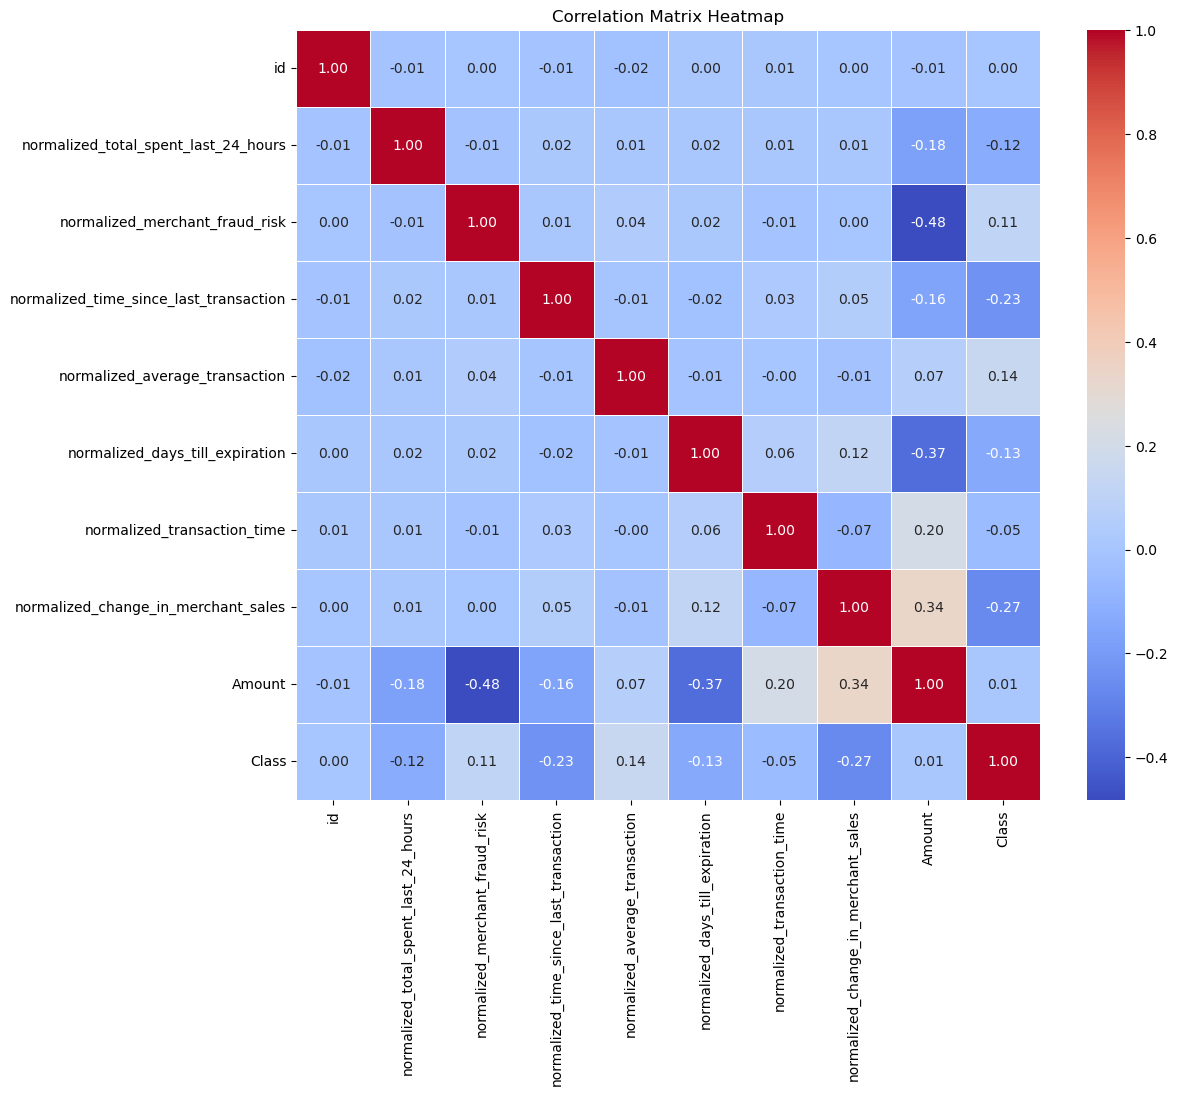

In [153]:
# PLOT Correlation matrix and explain your finding
# Assuming 'data' is your DataFrame
correlation_matrix = fraud.corr()  # Compute the correlation matrix

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))  # Adjust size for better readability
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

This dataframe is highly unbalanced
0--> legit transaction.
1--> fradulent transaction.

In [154]:
legit_only = fraud[fraud['Class'] == 0]
fraud_only = fraud[fraud['Class'] == 1]
print(legit_only.shape)
print(fraud_only.shape)


(9980, 10)
(20, 10)


In [155]:
fraud.groupby('Class').mean()

,id,normalized_total_spent_last_24_hours,normalized_merchant_fraud_risk,normalized_time_since_last_transaction,normalized_average_transaction,normalized_days_till_expiration,normalized_transaction_time,normalized_change_in_merchant_sales,Amount
Class,,,,,,,,,
0,4999.152605,0.031782,-0.004223,0.002658,-0.026576,-0.011627,-0.001897,-0.010288,85.248001
1,5172.850000,-5.386251,3.880162,-7.756987,4.523926,-3.972988,-1.465251,-6.981071,116.392000


Build a sample data set containing similar distribution containing the normal transaction and the fraud transaction.

In [156]:

fraud_oversampled = resample(fraud_only, 
                                replace=True,     # Sample with replacement
                                n_samples=len(legit_only),  # Match majority count
                                random_state=42) # Reproducible results
print(fraud_oversampled.shape)

(9980, 10)


In [157]:
fraud_new=pd.concat([legit_only,fraud_oversampled],axis=0)
fraud_new['Class'].value_counts()
fraud_new.groupby('Class').mean()

,id,normalized_total_spent_last_24_hours,normalized_merchant_fraud_risk,normalized_time_since_last_transaction,normalized_average_transaction,normalized_days_till_expiration,normalized_transaction_time,normalized_change_in_merchant_sales,Amount
Class,,,,,,,,,
0,4999.152605,0.031782,-0.004223,0.002658,-0.026576,-0.011627,-0.001897,-0.010288,85.248001
1,5181.053507,-5.464435,3.882341,-7.811765,4.552117,-4.007955,-1.471727,-7.036347,116.216545


In [175]:
X=fraud_new.drop(columns=['Class','normalized_total_spent_last_24_hours',],axis=1)
Y=fraud_new['Class']
X.info()
Y.info()
print(Y)

<class 'pandas.core.frame.DataFrame'>
Index: 19960 entries, 0 to 4577
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      19960 non-null  int64  
 1   normalized_merchant_fraud_risk          19960 non-null  float64
 2   normalized_time_since_last_transaction  19960 non-null  float64
 3   normalized_average_transaction          19960 non-null  float64
 4   normalized_days_till_expiration         19960 non-null  float64
 5   normalized_transaction_time             19960 non-null  float64
 6   normalized_change_in_merchant_sales     19960 non-null  float64
 7   Amount                                  19960 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 1.4 MB
<class 'pandas.core.series.Series'>
Index: 19960 entries, 0 to 4577
Series name: Class
Non-Null Count  Dtype
--------------  -----
19960 non-null  int64
dtype

In [176]:
#(c)	Divide the dataset into two sets (60% Train, 50% Test) and use the same logistic model in pervious sections and predict fraud.
# split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, stratify=Y, random_state=2)
print(X.shape, X_train.shape, X_test.shape)

(19960, 8) (9980, 8) (9980, 8)


In [177]:
# Increase max_iter to 1000 or more
model = LogisticRegression(max_iter=3000, random_state=42)
model.fit(X_train, Y_train)

LogisticRegression(max_iter=3000, random_state=42)

Model Evaluation

In [178]:
# accuracy on training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
print('Accuracy on Training data : ', training_data_accuracy)

Accuracy on Training data :  0.9369739478957916


In [179]:
# accuracy on test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy score on Test Data : ', test_data_accuracy)

Accuracy score on Test Data :  0.9321643286573146


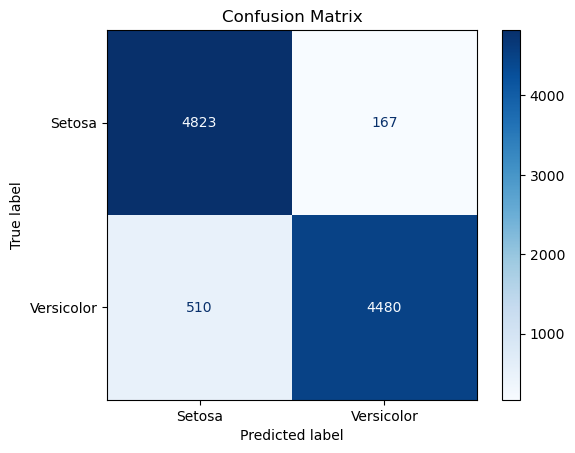


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      4990
           1       0.96      0.90      0.93      4990

    accuracy                           0.93      9980
   macro avg       0.93      0.93      0.93      9980
weighted avg       0.93      0.93      0.93      9980



In [183]:
# Create and display the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, classification_report


cm = confusion_matrix(Y_test, X_test_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Setosa', 'Versicolor'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(Y_test, X_test_prediction))

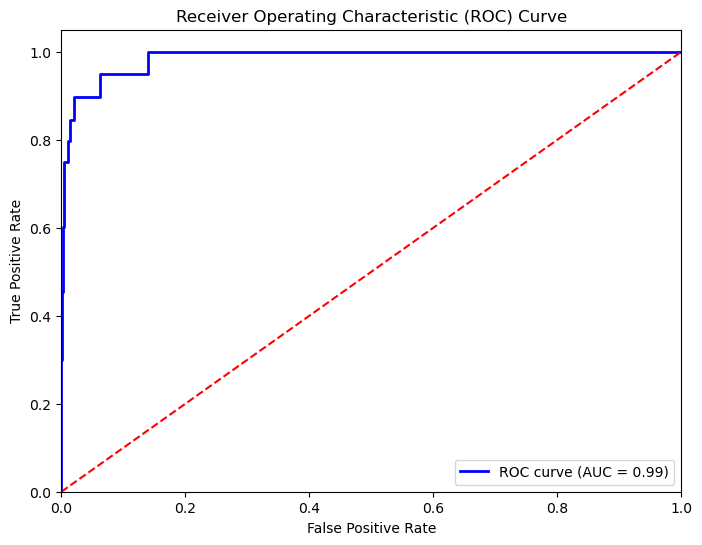

Accuracy on Training data: 0.9370
Accuracy on Test data: 0.9322


In [180]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_test_proba = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC for test data
fpr, tpr, _ = roc_curve(Y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f'Accuracy on Training data: {training_data_accuracy:.4f}')
print(f'Accuracy on Test data: {test_data_accuracy:.4f}')